In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')         # uncomment if working in  colab

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
data = pd.read_csv('enter csv path', encoding = 'latin1')
data = data.fillna(method = 'ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [ ]:
num_words, num_tags

(35179, 17)

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_Sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(), 
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[1]

[('Iranian', 'B-gpe'),
 ('officials', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('to', 'O'),
 ('get', 'O'),
 ('access', 'O'),
 ('to', 'O'),
 ('sealed', 'O'),
 ('sensitive', 'O'),
 ('parts', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('plant', 'O'),
 ('Wednesday', 'B-tim'),
 (',', 'O'),
 ('after', 'O'),
 ('an', 'O'),
 ('IAEA', 'B-org'),
 ('surveillance', 'O'),
 ('system', 'O'),
 ('begins', 'O'),
 ('functioning', 'O'),
 ('.', 'O')]

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx

{'sponsorship': 1,
 'Americans': 2,
 'al-Waili': 3,
 '268': 4,
 'Detainee': 5,
 'refugee': 6,
 'cheaper': 7,
 'Gaule': 8,
 '2,781': 9,
 '38.68': 10,
 'Biotechnology': 11,
 'Darren': 12,
 'Virginia': 13,
 'promises': 14,
 'oversaw': 15,
 'militarist': 16,
 'Investigators': 17,
 'Angelo': 18,
 'conferences': 19,
 'utilize': 20,
 'take-over': 21,
 'ai': 22,
 'Astronaut': 23,
 'suburbs': 24,
 'Tytler': 25,
 'Khawaza': 26,
 'deporting': 27,
 'graphic': 28,
 'Yayi': 29,
 'Taya': 30,
 'Secretary-General': 31,
 'Frost': 32,
 'Alliot-Marie': 33,
 'seabirds': 34,
 'atmosphere': 35,
 'Dili': 36,
 'Dream': 37,
 'Gurage': 38,
 'lack': 39,
 'Ludlam': 40,
 'firefight': 41,
 'Tutankhamun': 42,
 'soar': 43,
 'estimating': 44,
 'attitude': 45,
 'first-hand': 46,
 'Billingslea': 47,
 'nearly': 48,
 '02-May': 49,
 'Ilyas': 50,
 'Rezko': 51,
 'contestant': 52,
 'crossing': 53,
 'Gleneagles': 54,
 '184': 55,
 'SLA': 56,
 'clashing': 57,
 'Minar-e-Pakistan': 58,
 'Hajj': 59,
 'loosely': 60,
 'mouthpiece': 61

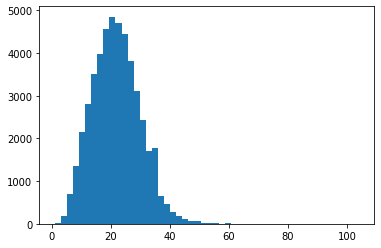

In [ ]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

input_word = Input(shape = (max_len))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy')>= 0.9975):
      print("Model stopped trainig")
      self.model.stop_training = True

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 1, verbose = 0, mode = 'max', restore_best_weights = False)
model_ckpt = ModelCheckpoint("enter checkpoints path", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
cb = myCallback()
callbacks = [cb, early_stopping, model_ckpt]

In [ ]:
history = model.fit(
    x_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 50,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/50
1080/1080 [==============================] - 208s 192ms/step - loss: 0.1895 - accuracy: 0.9569 - val_loss: 0.0680 - val_accuracy: 0.9804
Epoch 2/50
1080/1080 [==============================] - 211s 195ms/step - loss: 0.0518 - accuracy: 0.9848 - val_loss: 0.0495 - val_accuracy: 0.9852
Epoch 3/50
1080/1080 [==============================] - 211s 196ms/step - loss: 0.0373 - accuracy: 0.9886 - val_loss: 0.0472 - val_accuracy: 0.9857
Epoch 4/50
1080/1080 [==============================] - 212s 196ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 5/50
1080/1080 [==============================] - 211s 195ms/step - loss: 0.0263 - accuracy: 0.9916 - val_loss: 0.0477 - val_accuracy: 0.9861


In [ ]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 4s 26ms/step - loss: 0.0493 - accuracy: 0.9858


[0.04927726089954376, 0.985834002494812]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	Pred

------------------------------
He             O    	O
says           O    	O
doing          O    	O
so             O    	O
would          O    	O
cause          O    	O
long-term      O    	O
damage         O    	O
to             O    	O
Australia      B-geo	B-geo
's             O    	O
alliance       O    	O
with           O    	O
the            O    	O
U.S.           B-org	B-geo
Mr.            B-per	B-per
Howard         I-per	I-per
reiterated     O    	O
his            O    	O
support        O    	O
for            O    	O
the            O    	O
U.S.           B-geo	B-geo
position       O    	O
that           O    	O
foreign        O    	O
forces         O    	O
should         O    	O
only           O    	O
leave          O    	O
Iraq           B-geo	B-geo
when           O    	O
the            O    	O
Iraqis         B-gpe	B-gpe
can            O    	O
look           O    	O
after          O    	O
security       O    	O
themselves     O    	O
.              O 